# Introduction

The purpose of this file is to predict product sales using variational inference neural network. 

### Data description: 

What are the features?

    TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
    Radio: advertising dollars spent on Radio
    Newspaper: advertising dollars spent on Newspaper

What is the response?

    Sales: sales of a single product in a given market (in thousands of items)

What else do we know?

    Because the response variable is continuous, this is a regression problem.
    There are 200 observations (represented by the rows), and each observation is a single market.

from https://www.ritchieng.com/machine-learning-linear-regression/

The input is standarized so as to have a small dynamic range and to reduce the multicollinearity among variables. This prevents the explosion of the model parameters and the loss function. 

Use a <b>validation set </b>  as input and <b>RMSE metric </b> to tune the following hyperparameters:

* The standard deviation of the normal distribution (likelihood) used to model the output of the model. 
* The initial values of the model parameters
* The learning rate 
* The structure of the neural network: start with a relatively large network then gradually prune it. 
* The length of the training run



In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

# visualization
import seaborn as sns   # pairplot, PairGrid
import matplotlib.pyplot as plt

import pymc3 as pm

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import preprocessing

/home/bashar/anaconda3/envs/conda_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/bashar/anaconda3/envs/conda_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Read the data of csv file into a data frame
data=pd.read_csv('Advertising.csv')

# Remove the first column
data=data.drop(columns=['Unnamed: 0'])
data=data
data.head()


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
type(data.values)

numpy.ndarray

### Training data, Validation data, Test data

In [5]:
data_x=data[['TV' , 'radio' , 'newspaper']].values #
data_y=data['sales'].values[:,None]

data_x=preprocessing.scale(data_x)

train_x, test_x, train_y,test_y=train_test_split(data_x, data_y, test_size=0.25, random_state=1)
train_x, valid_x, train_y,valid_y=train_test_split(train_x, train_y, test_size=0.33, random_state=1)

#train_x=preprocessing.scale(train_x)
#valid_x=preprocessing.scale(valid_x)
#test_x=preprocessing.scale(test_x)


In [6]:
[train_x.shape, test_x.shape, valid_x.shape]

[(100, 3), (50, 3), (50, 3)]

### Data Visualisation

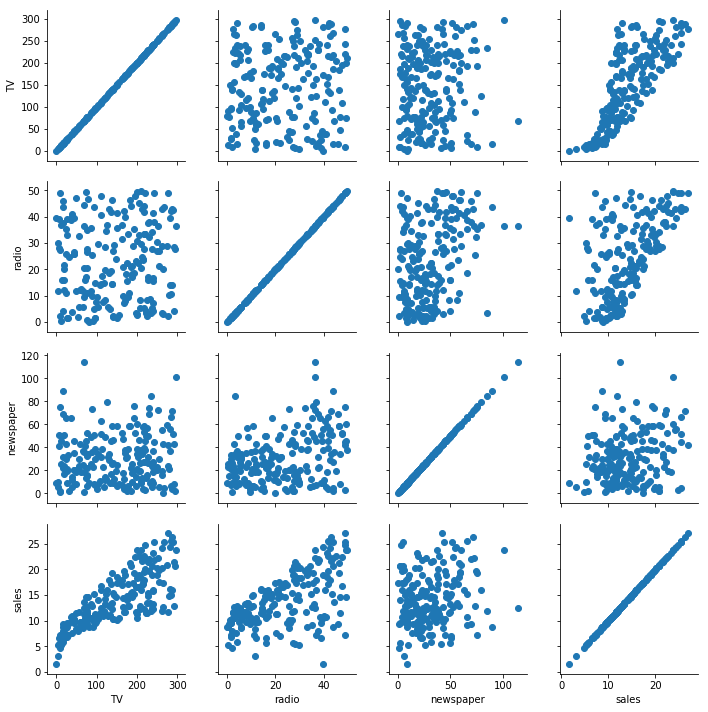

In [7]:
g = sns.PairGrid(data)
g = g.map(plt.scatter)


In [8]:
# Placeholders to store input and output data during training
x = tf.placeholder(tf.float32,shape=(None,3))
y_ = tf.placeholder( tf.float32,shape=(None,1))                   

In [9]:
n_input=3
n_hidden=50 # for 2 hidden layers
n_output=1


# define network weight shapes
n_layers=1

# define network weight shapes
layer_param_shapes = []
for i in range(n_layers + 1):
    if i == 0: # input layer
        W_shape = [n_input, n_hidden]
        b_shape = [n_hidden]
    elif i == n_layers: # last layer
        W_shape = [n_hidden, n_output]
        b_shape = [n_output]
    else: # hidden layers
        W_shape = [n_hidden, n_hidden]
        b_shape = [n_hidden]
    layer_param_shapes.append(W_shape)
    layer_param_shapes.append(b_shape)
    
    
def net(x, layer_params): # layer_params=[w1,b1,w2,b2,w3,b3]
    act1=tf.nn.relu(tf.matmul(x,layer_params[0])+layer_params[1]) 
    act2=tf.matmul(act1,layer_params[2])+layer_params[3]
    #act2=tf.nn.relu(tf.matmul(act1,layer_params[2])+layer_params[3])
    #act3=tf.matmul(act2,layer_params[4])+layer_params[5]
    output=act2
    return output

In [10]:
layer_param_shapes

[[3, 50], [50], [50, 1], [1]]

### Objective function

In [11]:
np.shape(train_y)

(100, 1)

In [12]:
# loglikelihood (cross entropy)

scale=tf.Variable(0.2, dtype=tf.float32)
def error_loss(nn_output, y_val, scale=scale):
    #SD=np.std(train_y).astype(np.float32)
    dist=tf.distributions.Normal(loc=0., scale=scale)
    return tf.reduce_sum(-1*dist.log_prob(nn_output-y_val))

# - loglikelihood

#def error_loss(nn_output, y_val):
        #return tf.reduce_sum(tf.square((y_val, nn_output)))
# - loglikelihood


def log_gauss(x,mu=0.,sigma=0.367): 
    dist=tf.distributions.Normal(loc=mu, scale=sigma)
    return dist.log_prob(x)


def complexity_loss(params, mus, sigmas):
    log_prior=tf.reduce_sum([tf.reduce_sum(log_gauss(param)) for param in params])
    #log_prior=tf.reduce_sum([tf.reduce_sum(scale_mixture(param)) for param in params])
    log_variational=tf.reduce_sum([tf.reduce_sum(log_gauss(params[j],mus[j], sigmas[j])) for j in range(len(mus))])
    return (log_variational-log_prior)

### Learnable parameters: The parameters of the variational distributions placed over the model's parameters


In [13]:
mus=[tf.Variable(tf.random_normal(shape, mean=0.0,stddev=.05,dtype=tf.float32)) for shape in layer_param_shapes]

rhos=[tf.Variable(tf.random_normal(shape, mean=-6.,stddev=.1,dtype=tf.float32)) for shape in layer_param_shapes]

sigmas=[tf.exp(rho) for rho in rhos]


# Algorithm steps

The Monte Carlo integration is used here for one sample drawn from the variational distribution

In [14]:
#1- draw epsilons from N(0,1)
epsilons =[tf.random_normal(shape, mean=0.0,stddev=1.0,dtype=tf.float32) for shape in layer_param_shapes]

#2- w=mu+sigma*epsilon

layer_params=[mus[j]+sigmas[j]*epsilons[j] for j in range(len(mus))]

#3- compute the network output using parameters in (2) and a batch of input images
output = net(x, layer_params)

#4- Loss function
loss1=complexity_loss(layer_params, mus, sigmas)
loss2=error_loss(output, y_, scale)
#lossL2 = tf.add_n([ tf.nn.l2_loss(mus[0]), tf.nn.l2_loss(mus[2]),tf.nn.l2_loss(mus[4])]) * 0.001
loss=loss1+loss2


In [15]:
error=tf.sqrt(tf.reduce_mean(tf.square(output-y_)))

In [16]:
learning_rate=0.001
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [17]:
# The following function is used to compute the predicted output
# for one sample drawn from the variational distribution

def compute_predicte(x, mus, sigmas, layer_param_shapes):
    epsilons =[tf.random_normal(shape, mean=0.0,stddev=1.,dtype=tf.float32) for shape in layer_param_shapes]
    params=[mus[j]+sigmas[j]*epsilons[j] for j in range(len(mus))]
    output=net(x, params)
    
    return output

predict=compute_predicte(x, mus, sigmas, layer_param_shapes)

In [18]:
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

In [19]:
#Training Loop:
n_epochs=5000
loss_list=[]
valid_list=[]
train_list=[]

for epoch in range(n_epochs):
    cost, _=sess.run([loss,train_step], feed_dict={x: train_x, y_:train_y})
    train_err=sess.run(error, feed_dict={x: train_x, y_:train_y})
    valid_err=sess.run(error, feed_dict={x: valid_x, y_:valid_y})

    loss_list.append(cost)
    train_list.append(train_err)
    valid_list.append(valid_err)


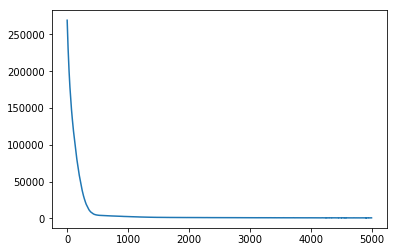

In [20]:
# The objective function
plt.plot(loss_list)

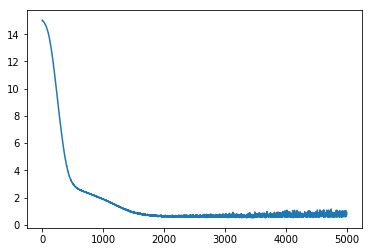

In [21]:
# The validation error is computing during training using the MAP estimate 
plt.plot(valid_list)


# Validation error 

In [22]:
# using Monte Carlo Integration with 100 samples drawn from the variational distribution
n_samples=100
out=np.zeros((n_samples,len(valid_x)))

for n in range(n_samples):
    out[n]=sess.run(predict,feed_dict={x:valid_x}).squeeze()

predicted=np.mean(out,0).squeeze() # Monte Carlo 
np.sqrt(np.mean(np.square(predicted-valid_y.squeeze()))) 


0.6281406278868025

# Test  error 

In [23]:
# The validation error is computing during training using 100 samples

n_samples=100
out=np.zeros((n_samples,len(test_x)))

for n in range(n_samples):
    out[n]=sess.run(predict,feed_dict={x:test_x}).squeeze()

predicted=np.mean(out,0).squeeze() # Monte Carlo 
RMSE=np.sqrt(np.mean(np.square(predicted-test_y.squeeze()))) 

print('RMSE=', RMSE)

RMSE= 0.525081170971991
